# Train Data
## The main purpose of this notebook is to play around with the training data used to fit the autoencoder.
## By using the somewhat random and noisey control (open source) data, can we better recognise periods of patterns as anomalies

In [2]:
# Import required libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model, load_model
import seaborn as sns
import datetime
import os.path

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [48]:
# Import preprocessed data
file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/'
DIAGRAM_FILE_PATH = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/diagrams/'
file_version = 'ws100num3derFalse'
sensors = ['back_angle', 'left_angle', 'right_angle']
file_name = f'{file_version}-control.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (3868, 100, 3)


### Attempt number 1
Window size = 100, NetArch = Dual Compression 0.4

In [8]:
time_code = '101500_0420'
model_file = f'{time_code}-model.h5'
model_file

'101500_0420-model.h5'

In [9]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 120, 2nd layer units: 60


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 120)          59520     
_________________________________________________________________
dropout (Dropout)            (None, 100, 120)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                43440     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 100, 60)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 60)           29040     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 120)          86880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 120)          0

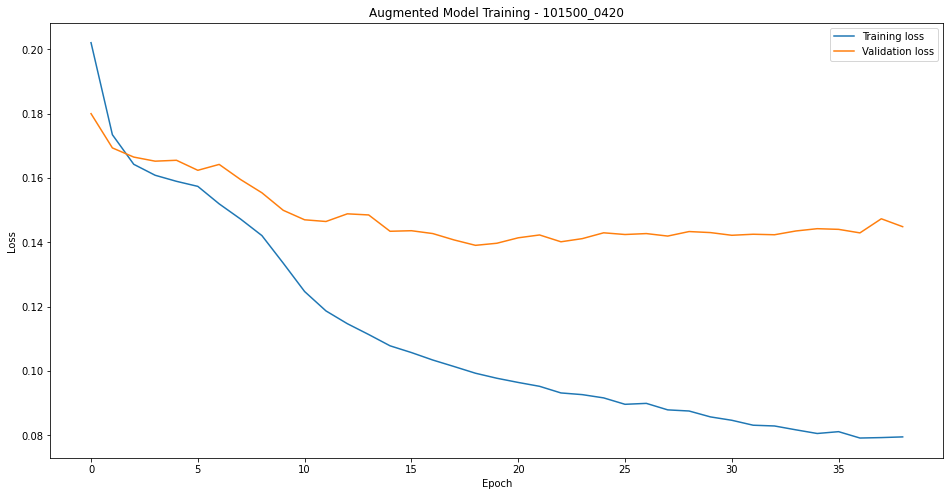

In [10]:
# Fit the model
if os.path.isfile(model_file):
    model = load_model(model_file)
    print(f"Loaded {model_file}")

    model.summary()
    for layer in model.layers:
        print(layer.input_shape)
else:
    # Define AutoEncoder architecture
    model = Sequential()
    # Encoder
    model.add(LSTM(units_one, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(LSTM(units_two, return_sequences=False))
    # Bridge
    model.add(RepeatVector(trainX.shape[1]))
    #Decoder
    model.add(LSTM(units_two, return_sequences=True))
    model.add(LSTM(units_one, return_sequences=True))
    model.add(Dropout(rate=0.2))
    model.add(TimeDistributed(Dense(trainX.shape[2])))
    model.compile(optimizer='adam', loss='mae')

    model.summary()
    for layer in model.layers:
        print(layer.input_shape)

    callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
    third_history = model.fit(trainX, trainX, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[callback])

    # Show the history of loss
    plt.figure(figsize=(16, 8))
    plt.plot(third_history.history['loss'], label='Training loss')
    plt.plot(third_history.history['val_loss'], label='Validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Augmented Model Training - {time_code}")
    plt.legend()

    diag_file_name = f'training-{time_code}.png'
    plt.savefig(f'{DIAGRAM_FILE_PATH}{diag_file_name}')

    
    model.save(model_file)
    print(f"Saved as {model_file}")

In [50]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of control training samples: {patientX.shape}')

Number of control training samples: (38087, 100, 3)


In [51]:
patientPredict = model.predict(patientX)

In [52]:
no_feats = trainX.shape[2]
seq_size = trainX.shape[1]
example = 10

In [53]:
from utils import *

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

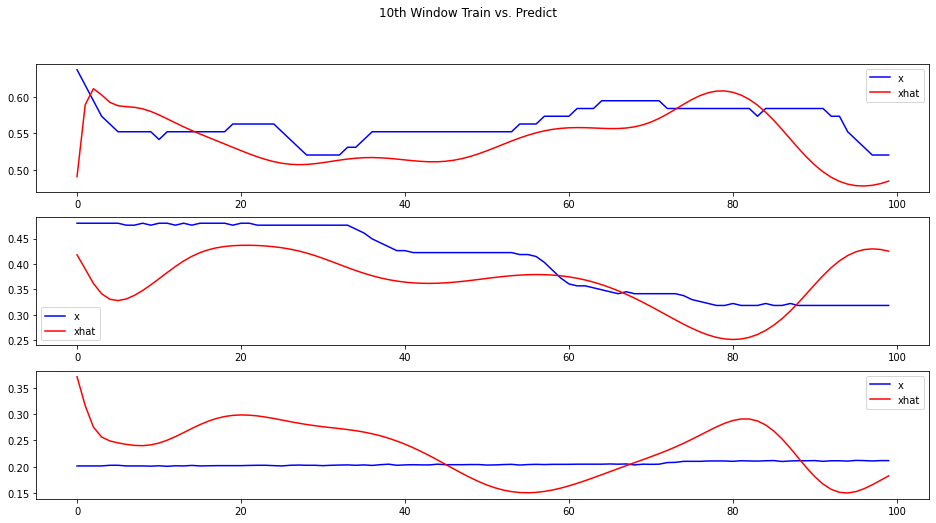

In [54]:
example_plot(example, no_feats, seq_size, patientX, patientPredict)

In [55]:
MAE = error_computation(patientX, patientPredict)
MAE.shape

(38087, 3)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

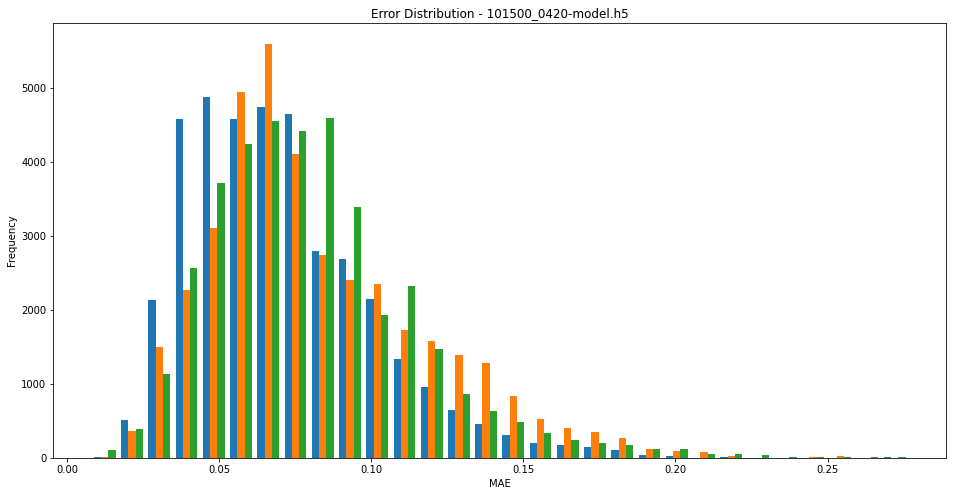

In [56]:
error_hist_and_save(MAE, model_file, DIAGRAM_FILE_PATH)

In [57]:
# Retrieve data and place with pd dataframe
patient_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/patient/patient_data.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['datetime'])
df = dataframe.loc[:,sensors]
df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'datetime'])

# Split test and train data
train, test = df.loc[df['Date'] <= '2011-12-01 11:38:00'], df.loc[df['Date'] > '2011-12-01 11:38:00']
train

,back_angle,left_angle,right_angle,Date
0,0.424307,0.572584,0.215395,2011-12-01 11:04:05.000
1,0.456290,0.568733,0.200416,2011-12-01 11:04:05.050
2,0.488273,0.564883,0.200416,2011-12-01 11:04:05.100
3,0.530917,0.557181,0.201110,2011-12-01 11:04:05.150
4,0.573561,0.541779,0.200416,2011-12-01 11:04:05.200
...,...,...,...,...
38182,0.626866,0.276088,0.527046,2011-12-01 11:35:54.100
38183,0.626866,0.276088,0.525659,2011-12-01 11:35:54.150
38184,0.616205,0.276088,0.524272,2011-12-01 11:35:54.200
38185,0.616205,0.276088,0.524272,2011-12-01 11:35:54.250


In [58]:
pct = 0.8
thresh = fixed_thresh(pct, MAE, len(train[seq_size:]))
thresh

array([0.22124272, 0.22124272, 0.22124272, ..., 0.22124272, 0.22124272,
       0.22124272])

In [59]:
anomaly_frame = anomaly_df(train, seq_size, MAE, thresh)
anomaly_frame.head()

,back_angle,left_angle,right_angle,Date,error,thresh,anomaly
100,0.584222,0.318444,0.211650,2011-12-01 11:04:10.000,0.063209,0.221243,False
101,0.584222,0.318444,0.210264,2011-12-01 11:04:10.050,0.064788,0.221243,False
102,0.573561,0.318444,0.211373,2011-12-01 11:04:10.100,0.065882,0.221243,False
103,0.573561,0.318444,0.211373,2011-12-01 11:04:10.150,0.066602,0.221243,False
104,0.552239,0.318444,0.210680,2011-12-01 11:04:10.200,0.066712,0.221243,False


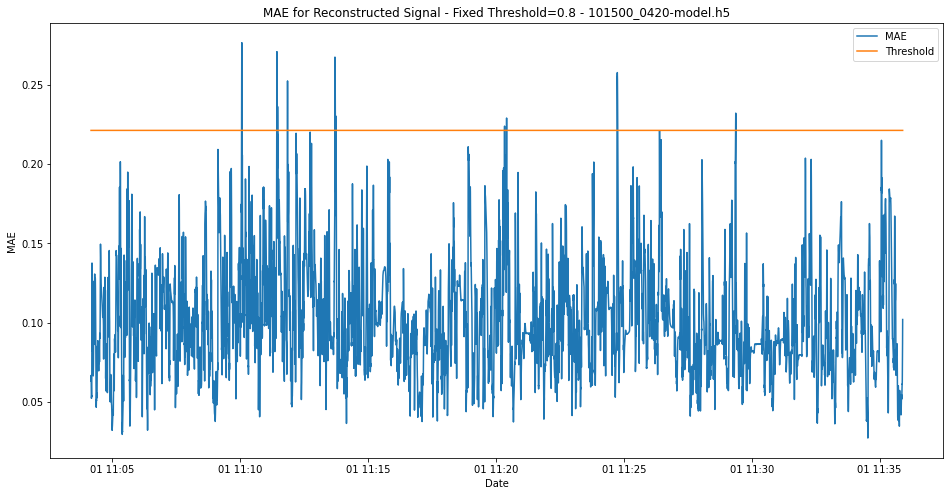

In [60]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, model_file, DIAGRAM_FILE_PATH)

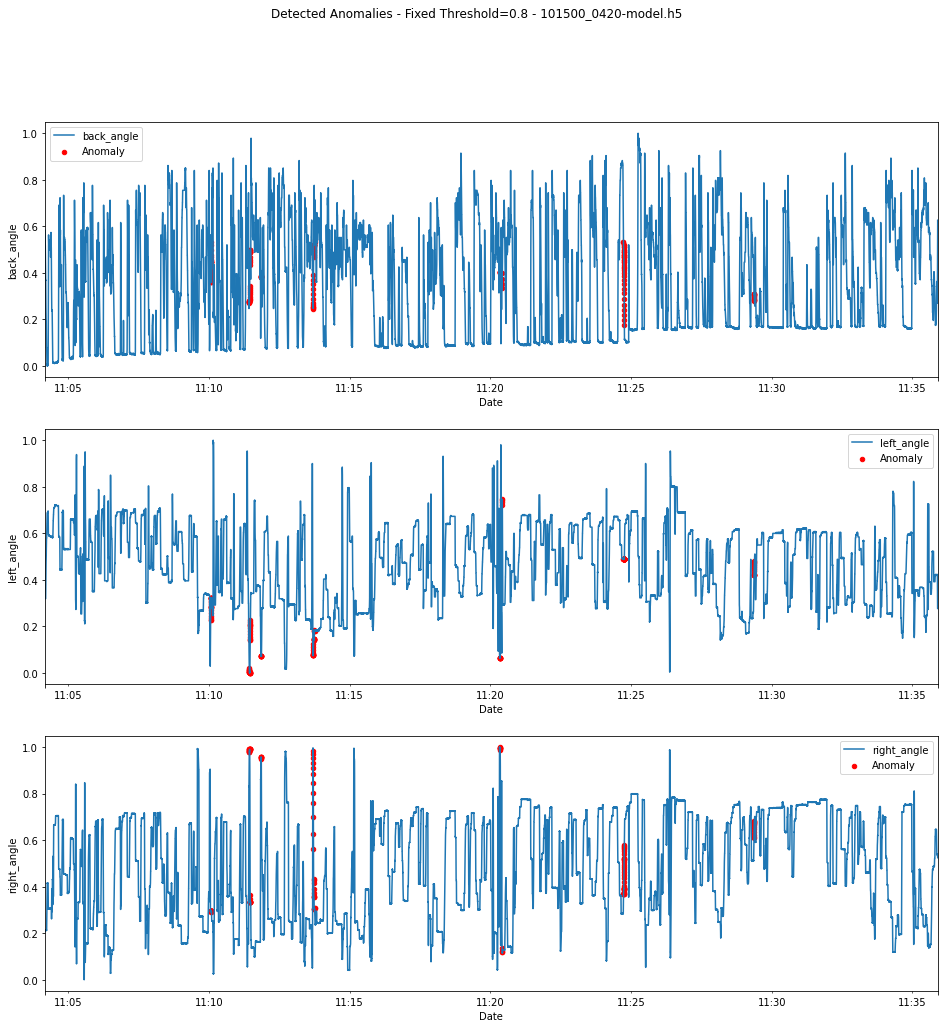

In [61]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, model_file, DIAGRAM_FILE_PATH)

Observations: Back Angle and the associated filtering of data seems to offset the error

## Trying to remove the back data and seeing what effect that has

Attempt 2: Remove back data

In [62]:
file_version = 'ws100num2derFalse'
sensors = ['left_angle', 'right_angle'] #'back_angle', 
file_name = f'{file_version}-control.npy'
path = file_path + file_name
trainX = np.load(path)
print(f'Number of control training samples: {trainX.shape}')

Number of control training samples: (3868, 100, 2)


In [63]:
compress = 0.4
units_one = int(trainX.shape[1] * trainX.shape[2] * compress)
units_two = int(units_one * 0.5)
print(f"1st layer units: {units_one}, 2nd layer units: {units_two}")

1st layer units: 80, 2nd layer units: 40


In [33]:
two_time_code = '110000_0420'
two_model_file = f'{two_time_code}-model.h5'
two_model_file

'110000_0420-model.h5'

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 80)           26560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 80)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40)                19360     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 40)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 40)           12960     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 80)           38720     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 80)          

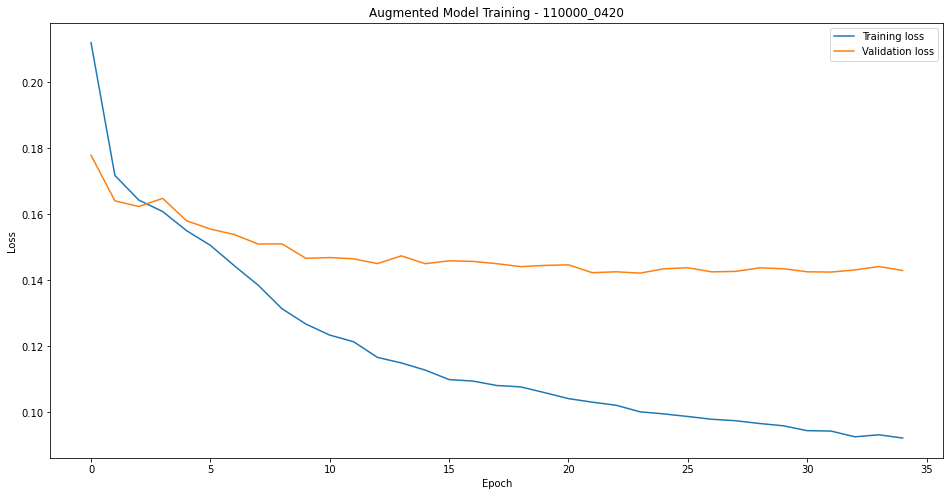

In [34]:
# Fit the model
if os.path.isfile(two_model_file):
    two_model = load_model(two_model_file)
    print(f"Loaded {two_model_file}")

    two_model.summary()
    for layer in two_model.layers:
        print(layer.input_shape)
else:
    # Define AutoEncoder architecture
    two_model = Sequential()
    # Encoder
    two_model.add(LSTM(units_one, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    two_model.add(Dropout(rate=0.2))
    two_model.add(LSTM(units_two, return_sequences=False))
    # Bridge
    two_model.add(RepeatVector(trainX.shape[1]))
    #Decoder
    two_model.add(LSTM(units_two, return_sequences=True))
    two_model.add(LSTM(units_one, return_sequences=True))
    two_model.add(Dropout(rate=0.2))
    two_model.add(TimeDistributed(Dense(trainX.shape[2])))
    two_model.compile(optimizer='adam', loss='mae')

    two_model.summary()
    for layer in two_model.layers:
        print(layer.input_shape)

    callback = EarlyStopping(monitor='loss', patience=2, min_delta=1e-3)
    two_history = two_model.fit(trainX, trainX, epochs=50, batch_size=32, validation_split=0.1, verbose=1, callbacks=[callback])

    # Show the history of loss
    plt.figure(figsize=(16, 8))
    plt.plot(two_history.history['loss'], label='Training loss')
    plt.plot(two_history.history['val_loss'], label='Validation loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Augmented Model Training - {two_time_code}")
    plt.legend()

    diag_file_name = f'training-{two_time_code}.png'
    plt.savefig(f'{DIAGRAM_FILE_PATH}{diag_file_name}')

    
    two_model.save(two_model_file)
    print(f"Saved as {two_model_file}")

In [66]:
# Load just the patient data
file_patient = f'{file_version}-patient-shaved.npy'
path = file_path + file_patient
patientX = np.load(path)
print(f'Number of patient testing samples: {patientX.shape}')

Number of patient testing samples: (38087, 100, 2)


In [67]:
patientPredict = two_model.predict(patientX)

In [68]:
no_feats = trainX.shape[2]
seq_size = trainX.shape[1]
example = 10

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

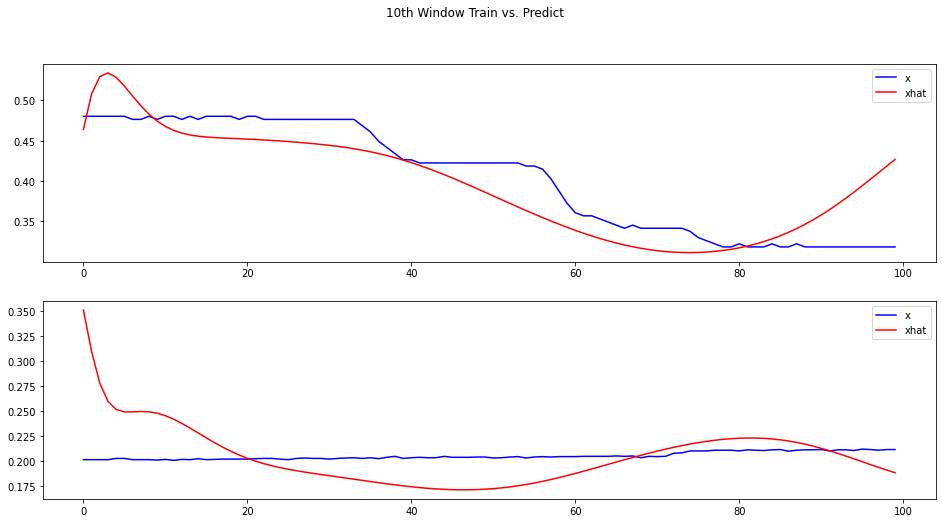

In [69]:
example_plot(example, no_feats, seq_size, patientX, patientPredict)

In [70]:
MAE = error_computation(patientX, patientPredict)
MAE.shape

(38087, 2)

<module 'matplotlib.pyplot' from '/Users/jamesmeyer/.pyenv/versions/fyp-env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

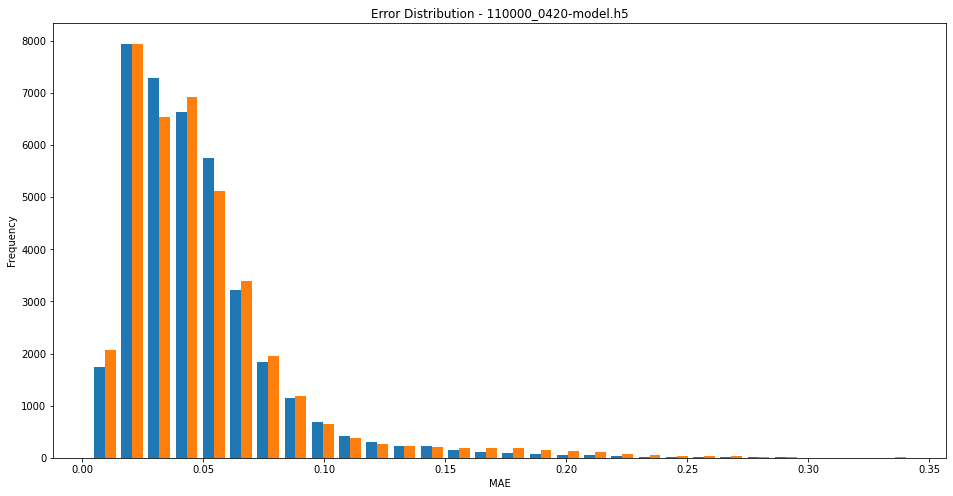

In [71]:
error_hist_and_save(MAE, two_model_file, DIAGRAM_FILE_PATH)

In [72]:
# Retrieve data and place with pd dataframe
patient_file_path = '/Users/jamesmeyer/University of Bath/Patient Simulator FYP - General/datasets/patient/patient_data.csv'
dataframe = pd.read_csv(patient_file_path, parse_dates=['datetime'])
df = dataframe.loc[:,sensors]
df.loc[:,'Date'] = pd.to_datetime(dataframe.loc[:,'datetime'])

# Split test and train data
train, test = df.loc[df['Date'] <= '2011-12-01 11:38:00'], df.loc[df['Date'] > '2011-12-01 11:38:00']
train

,left_angle,right_angle,Date
0,0.572584,0.215395,2011-12-01 11:04:05.000
1,0.568733,0.200416,2011-12-01 11:04:05.050
2,0.564883,0.200416,2011-12-01 11:04:05.100
3,0.557181,0.201110,2011-12-01 11:04:05.150
4,0.541779,0.200416,2011-12-01 11:04:05.200
...,...,...,...
38182,0.276088,0.527046,2011-12-01 11:35:54.100
38183,0.276088,0.525659,2011-12-01 11:35:54.150
38184,0.276088,0.524272,2011-12-01 11:35:54.200
38185,0.276088,0.524272,2011-12-01 11:35:54.250


In [73]:
pct = 0.8
thresh = fixed_thresh(pct, MAE, len(train[seq_size:]))
thresh

array([0.27305124, 0.27305124, 0.27305124, ..., 0.27305124, 0.27305124,
       0.27305124])

In [74]:
anomaly_frame = anomaly_df(train, seq_size, MAE, thresh)
anomaly_frame.head()

,left_angle,right_angle,Date,error,thresh,anomaly
100,0.318444,0.211650,2011-12-01 11:04:10.000,0.029472,0.273051,False
101,0.318444,0.210264,2011-12-01 11:04:10.050,0.030062,0.273051,False
102,0.318444,0.211373,2011-12-01 11:04:10.100,0.030414,0.273051,False
103,0.318444,0.211373,2011-12-01 11:04:10.150,0.030722,0.273051,False
104,0.318444,0.210680,2011-12-01 11:04:10.200,0.030485,0.273051,False


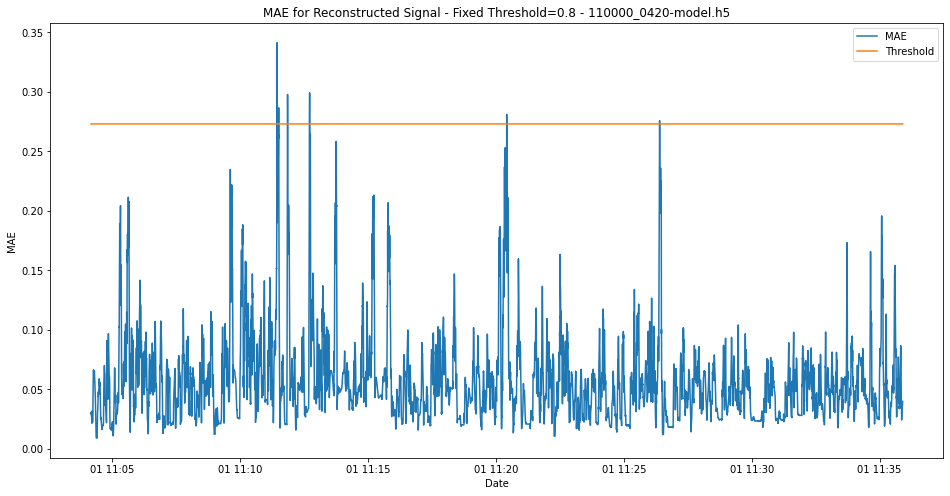

In [75]:
anomalies, _ = error_vs_thresh_plot_and_save(anomaly_frame, pct, two_model_file, DIAGRAM_FILE_PATH)

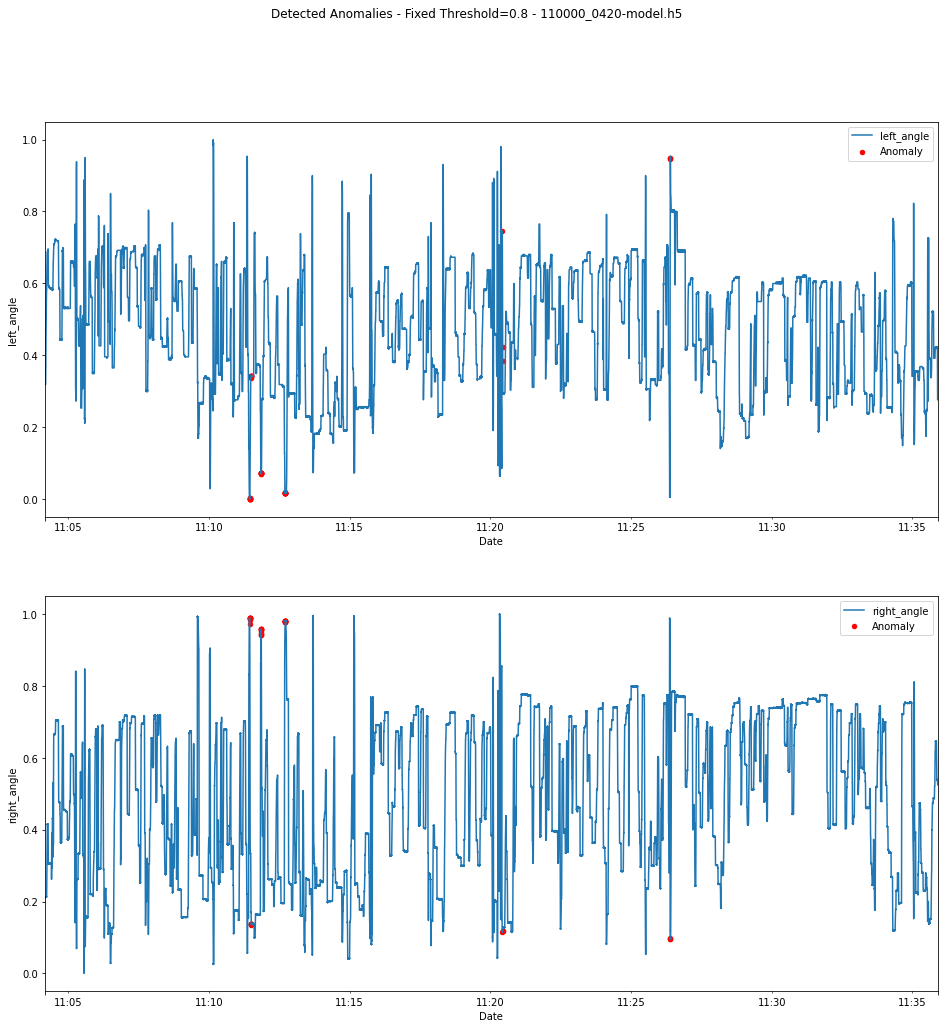

In [76]:
detect_anom_plot_and_save(no_feats, sensors, anomaly_frame, anomalies, pct, two_model_file, DIAGRAM_FILE_PATH)